In [1]:
!pip install plotly
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.8 MB/s eta 0:00:00


In [52]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import re

In [99]:
#Set path to data folder
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data')

# Read the combined data file
df1 = pd.read_excel('combined_data.xlsx')

Informacion general y descripcion de los datos:

In [100]:
df1.shape

(131976, 8)

In [101]:
df1.describe()

,id,last_scraped,accommodates,beds
count,1.319760e+05,131976,131976.000000,103304.000000
mean,5.630335e+17,2024-09-11 17:04:42.815057408,3.136017,1.930409
min,2.185300e+04,2024-03-22 00:00:00,1.000000,0.000000
25%,3.496711e+07,2024-06-15 00:00:00,2.000000,1.000000
50%,7.054828e+17,2024-09-11 00:00:00,2.000000,2.000000
75%,1.033379e+18,2024-12-12 00:00:00,4.000000,2.000000
max,1.369179e+18,2025-03-12 00:00:00,16.000000,40.000000
std,5.035184e+17,NaN,1.909158,1.514831


In [102]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131976 entries, 0 to 131975
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      131976 non-null  int64         
 1   last_scraped            131976 non-null  datetime64[ns]
 2   room_type               131976 non-null  object        
 3   price                   103465 non-null  object        
 4   neighbourhood_cleansed  131976 non-null  object        
 5   accommodates            131976 non-null  int64         
 6   bathrooms_text          131812 non-null  object        
 7   beds                    103304 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 8.1+ MB


In [103]:
df1.head()

,id,last_scraped,room_type,price,neighbourhood_cleansed,accommodates,bathrooms_text,beds
0,21853,2024-03-22,Private room,$31.00,Cármenes,1,1 bath,1.0
1,24805,2024-03-22,Entire home/apt,$92.00,Universidad,3,1 bath,2.0
2,204570,2024-03-22,Entire home/apt,$180.00,Cortes,5,2 baths,2.0
3,30320,2024-03-22,Entire home/apt,NaN,Sol,2,1 bath,NaN
4,205199,2024-03-22,Entire home/apt,$65.00,Universidad,2,1 bath,1.0


In [105]:
# Функция для извлечения числа из текста
def extract_bathroom_number(text):
    if pd.isna(text):
        return None
    # Ищем число в тексте
    match = re.search(r'(\d+(?:\.\d+)?)', str(text))
    if match:
        return float(match.group(1))
    return None

# Применяем функцию к колонке bathrooms_text
df1['bathrooms_numeric'] = df1['bathrooms_text'].apply(extract_bathroom_number)

# Проверяем результат
print("Первые 5 строк после преобразования:")
print(df1.head())

Первые 5 строк после преобразования:
       id last_scraped        room_type    price neighbourhood_cleansed  \
0   21853   2024-03-22     Private room   $31.00               Cármenes   
1   24805   2024-03-22  Entire home/apt   $92.00            Universidad   
2  204570   2024-03-22  Entire home/apt  $180.00                 Cortes   
3   30320   2024-03-22  Entire home/apt      NaN                    Sol   
4  205199   2024-03-22  Entire home/apt   $65.00            Universidad   

   accommodates bathrooms_text  beds  bathrooms_numeric  
0             1         1 bath   1.0                1.0  
1             3         1 bath   2.0                1.0  
2             5        2 baths   2.0                2.0  
3             2         1 bath   NaN                1.0  
4             2         1 bath   1.0                1.0  


In [106]:
# Сохраняем количество строк до удаления
initial_rows = len(df1)
# Оставляем только строки, где bathrooms_numeric больше 0 И меньше или равно 10
df1 = df1[(df1['bathrooms_numeric'] > 0) & (df1['bathrooms_numeric'] <= 10)]
# Выводим статистику
print(f"Было удалено {initial_rows - len(df1)} строк")
print(f"Осталось строк: {len(df1)}")
print("\nСтатистика по колонке bathrooms_numeric:")
print(df1['bathrooms_numeric'].describe())

Было удалено 2419 строк
Осталось строк: 129557

Статистика по колонке bathrooms_numeric:
count    129557.000000
mean          1.306047
std           0.621259
min           1.000000
25%           1.000000
50%           1.000000
75%           1.500000
max          10.000000
Name: bathrooms_numeric, dtype: float64


In [107]:
# Заменяем значения beds = 0 на значения из accommodates
df1.loc[df1['beds'] == 0, 'beds'] = df1.loc[df1['beds'] == 0, 'accommodates']

# Проверяем результат
print("Статистика по колонке beds после замены:")
print(df1['beds'].describe())
print("\nКоличество строк, где beds = 0:")
print((df1['beds'] == 0).sum())

Статистика по колонке beds после замены:
count    101250.000000
mean          2.074509
std           1.506136
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          40.000000
Name: beds, dtype: float64

Количество строк, где beds = 0:
0


Limpieza de datos, duplicados:

In [108]:
# Number of duplicates
print(f"Number of duplicates: {df1.duplicated().sum()}")

Number of duplicates: 0


Limpieza de datos, valores nulos:

In [109]:
# Общее количество пропущенных значений / Total number of missing values
print(f"Total number of missing values: {df1.isnull().sum().sum()}")

# Количество пропущенных значений по колонкам / Number of missing values by columns
print("\nNumber of missing values by columns:")
print(df1.isnull().sum())

# Процент пропущенных значений / # Percentage of missing values
print("\nPercentage of missing values:")
print((df1.isnull().sum() / len(df1) * 100).round(2))

Total number of missing values: 56460

Number of missing values by columns:
id                            0
last_scraped                  0
room_type                     0
price                     28153
neighbourhood_cleansed        0
accommodates                  0
bathrooms_text                0
beds                      28307
bathrooms_numeric             0
dtype: int64

Percentage of missing values:
id                         0.00
last_scraped               0.00
room_type                  0.00
price                     21.73
neighbourhood_cleansed     0.00
accommodates               0.00
bathrooms_text             0.00
beds                      21.85
bathrooms_numeric          0.00
dtype: float64


In [110]:

# Очищаем цены от символов и преобразуем в числа /Clean prices by removing symbols and convert to numbers
df1['price'] = df1['price'].str.replace('$', '').str.replace(',', '').astype(float)

# Проверяем количество нулевых значений /Check the number of null values
print(f"\nNumber of null values: {df1['price'].isna().sum()}")

# Удаляем строки с нулевыми значениями / Remove rows with zero values
df2 = df1[df1['price'] != 0]
df2 = df2.dropna(subset=['price'])
print(f"Number of rows after removing zero prices: {len(df2)}")




Number of null values: 28153
Number of rows after removing zero prices: 101404


In [111]:
# Количество пропущенных значений по колонкам /Number of missing values by columns
print("\nMissing values by columns:")
print(df2.isnull().sum())

# Процент пропущенных значений /Percentage of missing values
print("\nPercentage of missing values:")
print((df2.isnull().sum() / len(df2) * 100).round(2))


Missing values by columns:
id                          0
last_scraped                0
room_type                   0
price                       0
neighbourhood_cleansed      0
accommodates                0
bathrooms_text              0
beds                      196
bathrooms_numeric           0
dtype: int64

Percentage of missing values:
id                        0.00
last_scraped              0.00
room_type                 0.00
price                     0.00
neighbourhood_cleansed    0.00
accommodates              0.00
bathrooms_text            0.00
beds                      0.19
bathrooms_numeric         0.00
dtype: float64


In [112]:
df2.shape

(101404, 9)

In [113]:
# Количество уникальных значений в каждой колонке /Number of unique values in each column
print("\nNumber of unique values in each column:")
print(df2.nunique())


Number of unique values in each column:
id                        32048
last_scraped                 12
room_type                     4
price                       965
neighbourhood_cleansed      128
accommodates                 16
bathrooms_text               30
beds                         22
bathrooms_numeric            16
dtype: int64


In [114]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Анализ выбросов для каждой числовой колонки / Analysis of outliers for each numeric column
numeric_columns = ['price']
for col in numeric_columns:
    outliers = detect_outliers(df2, col)
    print(f"\nOutlier analysis for {col}:")
    print(f"Number of outliers: {len(outliers)}")
    print(f"Outliers percentage: {(len(outliers)/len(df2)*100):.2f}%")
    print("Outliers statistics:")
    print(outliers[col].describe())


Outlier analysis for price:
Number of outliers: 6339
Outliers percentage: 6.25%
Outliers statistics:
count     6339.000000
mean       661.814955
std       1367.985476
min        277.000000
25%        313.000000
50%        385.000000
75%        518.000000
max      23124.000000
Name: price, dtype: float64



Analysis of the impact of outliers for price:
Statistics with outliers:
count    101404.000000
mean        138.674332
std         371.735371
min           1.000000
25%          64.000000
50%         100.000000
75%         149.000000
max       23124.000000
Name: price, dtype: float64

Statistics without outliers:
count    95065.000000
mean       103.790954
std         56.293052
min          1.000000
25%         61.000000
50%         95.000000
75%        136.000000
max        276.000000
Name: price, dtype: float64


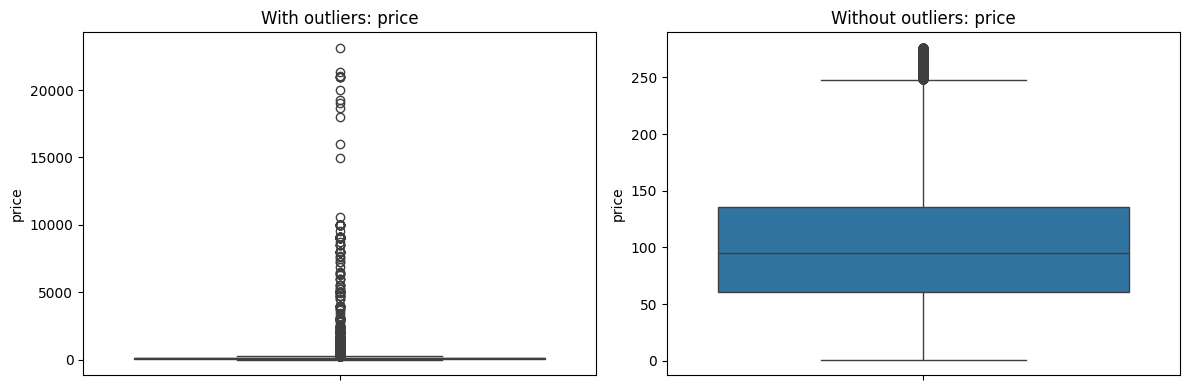

In [115]:
def analyze_outlier_impact(df, column):
    # Создаем копию без выбросов / Create a copy without outliers
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask = (df[column] >= lower_bound) & (df[column] <= upper_bound)

    df_no_outliers = df[mask].copy()

    # Сравниваем статистики / Compare statistics
    print(f"\nAnalysis of the impact of outliers for {column}:")
    print("Statistics with outliers:")
    print(df[column].describe())
    print("\nStatistics without outliers:")
    print(df_no_outliers[column].describe())

    # Визуализация / Visualization
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.boxplot(y=df[column])
    plt.title(f'With outliers: {column}')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_no_outliers[column])
    plt.title(f'Without outliers: {column}')
    plt.tight_layout()
    plt.show()

# Применяем анализ для каждой колонки / Apply analysis for each column
for col in numeric_columns:
    analyze_outlier_impact(df2, col)

In [116]:
def get_outliers_df(df, column):
   # Calculate boundaries for outliers / Вычисляем границы для выбросов
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Create a mask for outliers / Создаем маску для выбросов
    mask = (df[column] < lower_bound) | (df[column] > upper_bound)

    # Create a dataframe with only outliers / Создаем датафрейм только с выбросами
    outliers_df = df[mask].copy()

    # Add information about boundaries / Добавляем информацию о границах
    outliers_df[f'{column}_lower_bound'] = lower_bound
    outliers_df[f'{column}_upper_bound'] = upper_bound

    return outliers_df

# Example usage for one column / Пример использования для одной колонки
column_name = 'price'
outliers_df = get_outliers_df(df2, column_name)

# Print information about outliers / Выводим информацию о выбросах
print(f"Number of outliers in column {column_name}: {len(outliers_df)}")
print(f"Percentage of outliers:  {(len(outliers_df)/len(df2)*100):.2f}%")
print("\nOutliers statistics:")
print(outliers_df[column_name].describe())
print("\nFirst outliers:")
print(outliers_df[[column_name, f'{column_name}_lower_bound', f'{column_name}_upper_bound']].head(20))

Number of outliers in column price: 6339
Percentage of outliers:  6.25%

Outliers statistics:
count     6339.000000
mean       661.814955
std       1367.985476
min        277.000000
25%        313.000000
50%        385.000000
75%        518.000000
max      23124.000000
Name: price, dtype: float64

First outliers:
      price  price_lower_bound  price_upper_bound
108   309.0              -63.5              276.5
196   315.0              -63.5              276.5
205   379.0              -63.5              276.5
223   296.0              -63.5              276.5
250  1194.0              -63.5              276.5
290   510.0              -63.5              276.5
399   326.0              -63.5              276.5
405   325.0              -63.5              276.5
410   354.0              -63.5              276.5
420   500.0              -63.5              276.5
424   500.0              -63.5              276.5
425   500.0              -63.5              276.5
426   500.0              -63.5     

In [117]:
# Create a dataframe with prices above 1000 / Создаем датафрейм с ценами выше 1000
high_price_df = df2[df2['price'] > 1000]

# Print all rows with prices above 1000 / Выводим все строки с ценами выше 1000
print(f"\nNumber of rows with price above 1000: {len(high_price_df)}")
print("\nAll rows with price above 1000:")
print(high_price_df[['price']].sort_values('price', ascending=False))

# If more information about each row is needed / Если нужно вывести больше информации о каждой строке
print("\nDetailed information about rows with price above 1000:")
print(high_price_df.sort_values('price', ascending=False))


Number of rows with price above 1000: 396

All rows with price above 1000:
          price
43571   23124.0
108021  21347.0
33911   21013.0
9773    21000.0
95395   21000.0
...         ...
65998    1005.0
56340    1001.0
123597   1001.0
22669    1001.0
102042   1001.0

[396 rows x 1 columns]

Detailed information about rows with price above 1000:
                         id last_scraped        room_type    price  \
43571   1087700981397176960   2025-03-05  Entire home/apt  23124.0   
108021             18816591   2024-12-12  Entire home/apt  21347.0   
33911              45249073   2025-03-10  Entire home/apt  21013.0   
9773               45249073   2024-03-22  Entire home/apt  21000.0   
95395              45249073   2024-09-11  Entire home/apt  21000.0   
...                     ...          ...              ...      ...   
65998              29850257   2024-06-15  Entire home/apt   1005.0   
56340   1029047360999101056   2024-06-15  Entire home/apt   1001.0   
123597  10290473609991

In [118]:
# Create a copy of the dataframe for safe processing / Создаем копию датафрейма для безопасной обработки
df3 = df2.copy()

# Define reasonable price boundaries for Madrid / Определяем разумные границы цены для Мадрида
# Average nightly price in Madrid usually doesn't exceed 300-400€ / Средняя цена за ночь в Мадриде обычно не превышает 300-400€
# Setting upper limit at 1000€ as reasonable maximum / Установим верхнюю границу в 1000€ как разумный максимум
max_reasonable_price = 1000

# removing rows / Удаляем строки с нереальными ценами
df3 = df2[df2['price'] <= max_reasonable_price].copy()

print(f"Number of removed rows: {len(df2) - len(df3)}")
print(f"Percentage of removed rows: {((len(df2) - len(df2))/len(df2)*100):.2f}%")

Number of removed rows: 396
Percentage of removed rows: 0.00%


In [119]:
# Общее количество пропущенных значений / Total number of missing values
print(f"Total number of missing values: {df3.isnull().sum().sum()}")

# Количество пропущенных значений по колонкам / Number of missing values by columns
print("\nNumber of missing values by columns:")
print(df3.isnull().sum())

# Процент пропущенных значений / # Percentage of missing values
print("\nPercentage of missing values:")
print((df3.isnull().sum() / len(df3) * 100).round(2))

Total number of missing values: 195

Number of missing values by columns:
id                          0
last_scraped                0
room_type                   0
price                       0
neighbourhood_cleansed      0
accommodates                0
bathrooms_text              0
beds                      195
bathrooms_numeric           0
dtype: int64

Percentage of missing values:
id                        0.00
last_scraped              0.00
room_type                 0.00
price                     0.00
neighbourhood_cleansed    0.00
accommodates              0.00
bathrooms_text            0.00
beds                      0.19
bathrooms_numeric         0.00
dtype: float64


In [120]:
!pip install --upgrade scikit-learn
!pip install category_encoders
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

# OneHotEncoding for room_type
ohe = OneHotEncoder(sparse_output=False)
room_type_encoded = ohe.fit_transform(df3[['room_type']])
room_type_columns = ohe.get_feature_names_out(['room_type'])
room_type_df = pd.DataFrame(room_type_encoded, columns=room_type_columns, index=df3.index)

# TargetEncoding for neighbourhood_cleansed
te = TargetEncoder()
neighbourhood_encoded = te.fit_transform(df3[['neighbourhood_cleansed']], df3['price'])
neighbourhood_encoded.columns = ['neighbourhood_encoded']
neighbourhood_encoded.index = df3.index

# Combine encoded features with original dataframe
df_final = pd.concat([
    df3[['id', 'last_scraped', 'price', 'accommodates', 'bathrooms_numeric', 'beds']],
    room_type_df,
    neighbourhood_encoded
], axis=1)

# Reset index to ensure proper ordering
df_final = df_final.reset_index(drop=True)

# Display results
print("\nEncoded dataframe shape:", df_final.shape)
print("\nFirst 5 rows of encoded dataframe:")
print(df_final.head())
print("\nColumn names after encoding:")
print(df_final.columns.tolist())




Encoded dataframe shape: (101008, 11)

First 5 rows of encoded dataframe:
       id last_scraped  price  accommodates  bathrooms_numeric  beds  \
0   21853   2024-03-22   31.0             1                1.0   1.0   
1   24805   2024-03-22   92.0             3                1.0   2.0   
2  204570   2024-03-22  180.0             5                2.0   2.0   
3  205199   2024-03-22   65.0             2                1.0   1.0   
4  209373   2024-03-22   32.0             1                1.0   1.0   

   room_type_Entire home/apt  room_type_Hotel room  room_type_Private room  \
0                        0.0                   0.0                     1.0   
1                        1.0                   0.0                     0.0   
2                        1.0                   0.0                     0.0   
3                        1.0                   0.0                     0.0   
4                        0.0                   0.0                     1.0   

   room_type_Shared roo

In [121]:
df_final.to_csv('final_data.csv', index=False)

In [122]:
# Install ydata-profiling
!pip install ydata-profiling

from ydata_profiling import ProfileReport

# Generate EDA report
profile = ProfileReport(df_final,
                       title="Airbnb Data Profiling Report",
                       html={'style': {'full_width': True}},
                       progress_bar=False)

# Display the report in notebook
profile.to_notebook_iframe()

100%|██████████| 11/11 [00:00<00:00, 85.01it/s]
